### Chile Inflation Nowcast
* This code is a first attempt as using the Cleveland Fed Nowcast Methodology to predict headline inflation
* https://www.clevelandfed.org/indicators-and-data/inflation-nowcasting
* Hope to expand it to include additional explanatory variables soon

In [81]:
#Import statements
import pandas as pd 
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
from fredapi import Fred
from datetime import datetime
import config
fred = Fred(api_key=config.api_key)


In [82]:
#Get Exchange rate data and Energy price data from Yahoo Finance

# Define the ticker list
# Currently using the exchange rate and the Oil price
tickers_list = ['CLP=X','CL=F']

# Fetch the data
data = yf.download(tickers_list,'1990-1-1')['Adj Close']

#Organize the data for merging and convert to monthly % changes
dfyf = data.groupby(pd.PeriodIndex(data.index, freq="M"))[tickers_list].mean()
dfyf.reset_index(inplace=True)
dfyf['Date'] = dfyf['Date'].dt.strftime('%Y/%m/%d')
dfyf['Date'] = pd.to_datetime(dfyf['Date'])
#Merging dates start first day of month, so use that detail
dfyf['Date'] = dfyf['Date'].apply(lambda x: datetime(x.year, x.month, 1))
dfyf = dfyf.set_index('Date')

dfyf = 100*dfyf[tickers_list].pct_change(1)
dfyf.head()

[*********************100%***********************]  2 of 2 completed


,CLP=X,CL=F
Date,,
2000-08-01,NaN,NaN
2000-09-01,NaN,4.072076
2000-10-01,NaN,-2.650699
2000-11-01,NaN,3.916269
2000-12-01,NaN,-17.246714


In [83]:
#Define function for collecting data from FRED
def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict()):
    df_collect = pd.DataFrame()

    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
        #If user changes the 
        if freq != "":
            info_add.loc['cur_freq', var] = freq
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store


CPALTT01CLM657N
CPGREN01CLM657N
CPGRLE01CLM657N
WPUID61


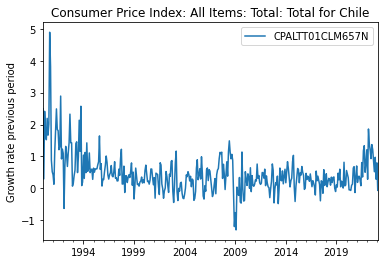

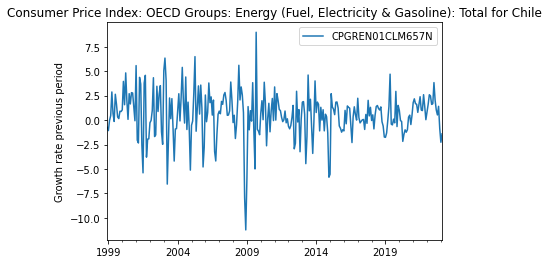

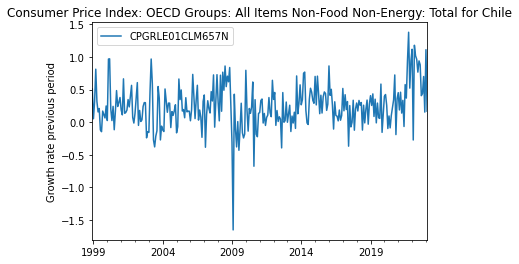

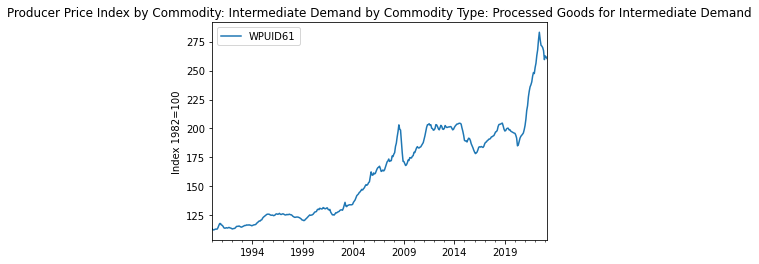

In [84]:
#Define FRED codes to search for 
FRED_list = ['CPALTT01CLM657N','CPGREN01CLM657N','CPGRLE01CLM657N','WPUID61']

s_d ='1990-01-01'
e_d='2023-03-01'

#Collect variables into a monthly df
df_collect_m, dfinfo_m = fredget(FRED_list, s_d, e_d, freq = "m", plots=True)
#Convert this series to MoM % changes
df_collect_m['WPUID61'] = df_collect_m['WPUID61'].pct_change(1)*100

<AxesSubplot:>

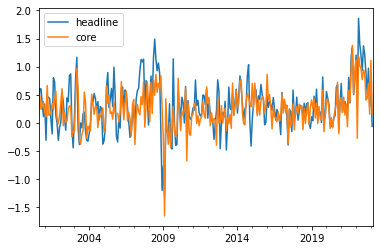

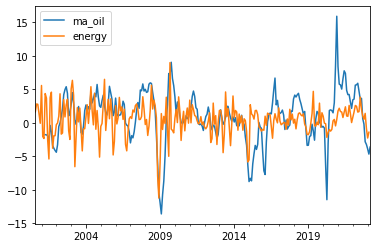

In [85]:
df = dfyf.merge(df_collect_m, how='inner',left_index=True,right_index=True)

rename_cols = {"CPALTT01CLM657N":"headline","CPGREN01CLM657N":"energy","CPGRLE01CLM657N":"core","WPUID61":"USppi","CLP=X":"exrate","CL=F":"oil"}

df = df.rename(columns=rename_cols)
df['ma_oil'] = df['oil'].rolling(window=8).mean()

df[['headline','core']].plot()
df[['ma_oil','energy']].plot()


#This concludes the data collection

In [95]:
import statsmodels.api as sm

MA_fit_list = ['core']
reglist = list()
lag_order = 12
df_reg = df

for f in MA_fit_list:
    for i in range(1,lag_order+1):
        varname = f'{f}_L_{i}'
        reglist.append(varname)
        #df_reg[varname] = df_reg[f].shift(i) 
        df_reg[varname] = df_reg[f].shift(i) 
    
df_reg['lag_headline'] = df_reg['headline'].shift(1) 
df_reg['lag2_headline'] = df_reg['headline'].shift(2) 
df_reg['lag3_headline'] = df_reg['headline'].shift(3) 


df_reg['core_fcast'] =  df_reg[reglist].mean(axis=1)
print(reglist)
df_sample = df_reg.loc['2005-01-01':'2023-01-01'].copy()
split_date = '2019-1-1'
df_train = df_sample.loc[df_sample.index <= split_date].copy()
df_test = df_sample.loc[df_sample.index > split_date].copy()

x_set = ['oil','exrate','lag_headline','USppi']

y_set = ['headline']
x = df_train[x_set]
x_test = df_test[x_set]

y = df_train[y_set]
x = sm.add_constant(x)
x_test = sm.add_constant(x_test)
model = sm.OLS(y, x).fit()
model.summary()


        

['core_L_1', 'core_L_2', 'core_L_3', 'core_L_4', 'core_L_5', 'core_L_6', 'core_L_7', 'core_L_8', 'core_L_9', 'core_L_10', 'core_L_11', 'core_L_12']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               headline   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     29.48
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           1.80e-18
Time:                        23:04:44   Log-Likelihood:                -44.521
No. Observations:                 169   AIC:                             99.04
Df Residuals:                     164   BIC:                             114.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1277      0.030      4.315      0.000       0.069       0.186
oil              0.0084      0.004      2.209      0.029       0.001       0.016
exrate           0.0521      0.010      5.386      0.000       0.033       0.071
lag_headline     0.4284      0.060      7.097      0.000       0.309       0.548
USppi            0.1021      0.027      3.785      0.000       0.049       0.155
==============================================================================
Omnibus:                        4.236   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                4.237
Skew:                           0.226   Prob(JB):                        0.120
Kurtosis:                       3.630   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

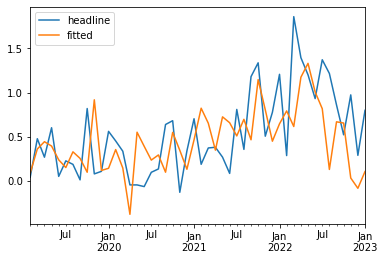

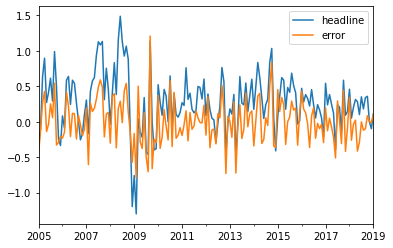

In [100]:
df_train['fitted'] = model.fittedvalues
df_test['fitted'] = model.predict(x_test)
df_train['error'] = df_train['headline'] - df_train['fitted']
df_test[['headline','fitted']].plot()

df_train[['headline','error']].plot()

#df_train['error'].plot()


In [88]:
x_AR = df_train['lag_headline']
x_AR = sm.add_constant(x_AR)
model = sm.OLS(y, x_AR).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               headline   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     48.51
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           8.81e-11
Time:                        22:49:08   Log-Likelihood:                -67.390
No. Observations:                 157   AIC:                             138.8
Df Residuals:                     155   BIC:                             144.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1477      0.036      4.155      0.000       0.077       0.218
lag_headline     0.4857      0.070      6.965      0.000       0.348       0.623
==============================================================================
Omnibus:                        5.837   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                6.871
Skew:                          -0.249   Prob(JB):                       0.0322
Kurtosis:                       3.896   Cond. No.                         2.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""